### Requirements import

In [45]:
import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gc
import os
import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Dense

### Use GPU

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1}, log_device_placement=True ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro GV100, pci bus id: 0000:73:00.0, compute capability: 7.0



In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16453010223582428293
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31792824320
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13554762636494567216
physical_device_desc: "device: 0, name: Quadro GV100, pci bus id: 0000:73:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


### Import Train set

In [4]:
x = np.load('../Preprocessing/train_crop.npy',allow_pickle=True).astype(np.float32)
y_label = np.load('../Preprocessing/train.npy',allow_pickle=True)

In [5]:
#Convert label to oneho
y = y_label[:,0].astype(np.float32)

### Image Augmentation

In [6]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.2),
    ],
    name="img_augmentation",
)

### Build the new model based on ResNet50 with augmentation

In [7]:
# Build the new model based on ResNet50
def get_model_with_augmentation(num_classes=256):
    '''
    Build the new model based on ResNet50 with image augmentation 
    
    Argument:
    num_classes -- (int) number of classes
    
    Return:
    model -- the new compiled model
    '''
    inputs = layers.Input(shape=(224,224,3))
    x = img_augmentation(inputs)
    # Base ResNet50 model
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(base_model.output)

    # Dense layer for classification
    x = layers.Dense(256, activation='softmax', kernel_initializer='glorot_uniform')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=x)

    # Print model summary for inspection
    model.summary()

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### Build the new model based on ResNet50 with LRS(Learning Rate Scheduler)

In [8]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 2:
        lr *= 0.1
    return lr

In [9]:
def get_model_with_lrs(num_classes=256):
    '''
    Build the new model based on ResNet50 with LRS
    
    Argument:
    num_classes -- (int) number of classes
    
    Return:
    model -- the new compiled model
    '''
    inputs = layers.Input(shape=(224,224,3))
    orig_model = ResNet50(include_top=False, weights='imagenet', pooling='avg', classes=num_classes)
    out = layers.Dense(256, activation='softmax', kernel_initializer='glorot_uniform')(orig_model.output)
    model = Model(inputs=orig_model.input, outputs=out)
    optimizer = Adam(learning_rate=lr_schedule(0))
    model.compile(loss= "sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

### Build the new model based on ResNet50 with Augmentation and LRS

In [10]:
def model_with_augmentation_and_lrs(num_classes=256):
    '''
    Build the new model based on ResNet50 with augmentation and LRS
    
    Argument:
    num_classes -- (int) number of classes
    
    Return:
    model -- the new compiled model
    '''
    inputs = layers.Input(shape=(224,224,3))
    x = img_augmentation(inputs)
    orig_model = ResNet50(include_top=False, weights='imagenet',input_tensor=x, pooling='avg', classes=num_classes)
    densenet_out = orig_model.layers[-1].output
    out = Dense(256, activation='softmax', kernel_initializer='glorot_uniform')(densenet_out)
    model = Model(inputs=orig_model.input, outputs=out)
    optimizer = Adam(learning_rate=lr_schedule(0))
    model.compile(loss= "sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [11]:
densemodel_aug = get_model_with_augmentation(256)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  multiple             0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['img_augmentation[0][0]']       
                                                                                                  
 conv1_conv (Conv2D)  

In [12]:
densemodel_aug.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  multiple             0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['img_augmentation[0][0]']       
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']          

### Train the augmentation model and save the best weights and history

In [13]:
filepath="./Models/ResNet50_crop_aug.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]
history_aug = densemodel_aug.fit(x, y, epochs=12, batch_size=32, validation_split=0.25, callbacks=callbacks_list)

Train on 17869 samples, validate on 5957 samples
Epoch 1/12
17869/17869 [==============================] - ETA: 0s - loss: 4.1682 - accuracy: 0.1823

C:\Users\skhatta\AppData\Local\anaconda3\envs\s_myenv\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.21303, saving model to ./Models\ResNet50_crop_aug.hdf5
17869/17869 [==============================] - 194s 11ms/sample - loss: 4.1682 - accuracy: 0.1823 - val_loss: 3.9777 - val_accuracy: 0.2130
Epoch 2/12
17869/17869 [==============================] - ETA: 0s - loss: 2.5711 - accuracy: 0.4155
Epoch 2: val_accuracy improved from 0.21303 to 0.35286, saving model to ./Models\ResNet50_crop_aug.hdf5
17869/17869 [==============================] - 147s 8ms/sample - loss: 2.5711 - accuracy: 0.4155 - val_loss: 2.9779 - val_accuracy: 0.3529
Epoch 3/12
17869/17869 [==============================] - ETA: 0s - loss: 1.7368 - accuracy: 0.5780
Epoch 3: val_accuracy improved from 0.35286 to 0.45409, saving model to ./Models\ResNet50_crop_aug.hdf5
17869/17869 [==============================] - 153s 9ms/sample - loss: 1.7368 - accuracy: 0.5780 - val_loss: 2.5168 - val_accuracy: 0.4541
Epoch 4/12
17869/17869 [==============================] - ETA: 0s - loss

In [14]:
np.save("./History/history_resnet50_aug.npy",history_aug.history)

In [15]:
lr_callback = LearningRateScheduler(lr_schedule)
densemodel_lrs = get_model_with_lrs(256)

In [16]:
densemodel_lrs.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

### Train the LRS model and save the best weights and history

In [17]:
from keras.callbacks import ModelCheckpoint
filepath="./Models/ResNet50_crop_lrs.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list = [lr_callback, checkpoint]
history_lrs = densemodel_lrs.fit(x, y, epochs=12, batch_size=32, validation_split=0.25, callbacks=callbacks_list)

Train on 17869 samples, validate on 5957 samples
Epoch 1/12
17869/17869 [==============================] - ETA: 0s - loss: 4.3932 - accuracy: 0.1537
Epoch 1: val_accuracy improved from -inf to 0.19909, saving model to ./Models\ResNet50_crop_lrs.hdf5
17869/17869 [==============================] - 228s 13ms/sample - loss: 4.3932 - accuracy: 0.1537 - val_loss: 4.0520 - val_accuracy: 0.1991 - lr: 0.0010
Epoch 2/12
17869/17869 [==============================] - ETA: 0s - loss: 2.8028 - accuracy: 0.3703
Epoch 2: val_accuracy improved from 0.19909 to 0.26926, saving model to ./Models\ResNet50_crop_lrs.hdf5
17869/17869 [==============================] - 168s 9ms/sample - loss: 2.8028 - accuracy: 0.3703 - val_loss: 3.5198 - val_accuracy: 0.2693 - lr: 0.0010
Epoch 3/12
17869/17869 [==============================] - ETA: 0s - loss: 1.9770 - accuracy: 0.5287
Epoch 3: val_accuracy improved from 0.26926 to 0.38543, saving model to ./Models\ResNet50_crop_lrs.hdf5
17869/17869 [========================

In [18]:
np.save("./History/history_resnet50_lrs.npy",history_lrs.history)

In [19]:
densemodel_aug_lrs = model_with_augmentation_and_lrs(256)

In [20]:
densemodel_aug_lrs.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  multiple             0           ['input_4[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['img_augmentation[1][0]']       
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']        

### Train the Aug+LRS model and save the best weights and history

In [21]:
from keras.callbacks import ModelCheckpoint
filepath="./Models/ResNet50_crop_aug_lrs.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list = [lr_callback, checkpoint]
history_aug_lrs = densemodel_aug_lrs.fit(x, y, epochs=12, batch_size=32, validation_split=0.25, callbacks=callbacks_list)

Train on 17869 samples, validate on 5957 samples
Epoch 1/12
17869/17869 [==============================] - ETA: 0s - loss: 3.9641 - accuracy: 0.2144
Epoch 1: val_accuracy improved from -inf to 0.22830, saving model to ./Models\ResNet50_crop_aug_lrs.hdf5
17869/17869 [==============================] - 267s 15ms/sample - loss: 3.9641 - accuracy: 0.2144 - val_loss: 3.7595 - val_accuracy: 0.2283 - lr: 0.0010
Epoch 2/12
17869/17869 [==============================] - ETA: 0s - loss: 2.3579 - accuracy: 0.4590
Epoch 2: val_accuracy improved from 0.22830 to 0.39752, saving model to ./Models\ResNet50_crop_aug_lrs.hdf5
17869/17869 [==============================] - 150s 8ms/sample - loss: 2.3579 - accuracy: 0.4590 - val_loss: 2.7863 - val_accuracy: 0.3975 - lr: 0.0010
Epoch 3/12
17869/17869 [==============================] - ETA: 0s - loss: 1.5930 - accuracy: 0.6122
Epoch 3: val_accuracy did not improve from 0.39752
17869/17869 [==============================] - 150s 8ms/sample - loss: 1.5930 - ac

In [22]:
np.save("./History/history_resnet50_aug_lrs.npy",history_aug_lrs.history)

In [23]:
#release RAM
del x, y
gc.collect()

0

### Compare the different models

In [24]:
history = np.load("./History/history_resnet50.npy", allow_pickle=True).item()

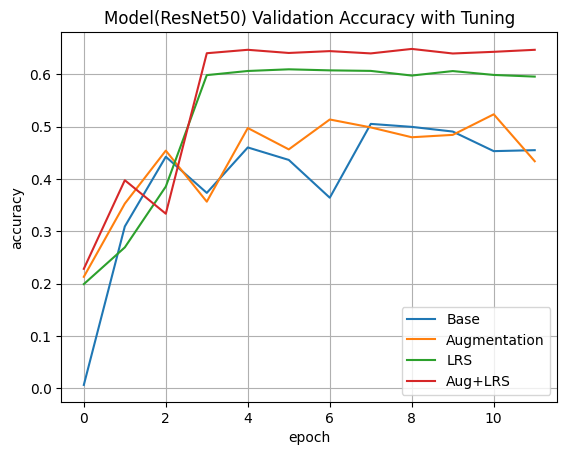

In [28]:
plt.plot(history['val_accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.plot(history_lrs.history['val_accuracy'])
plt.plot(history_aug_lrs.history['val_accuracy'])
plt.title('Model(ResNet50) Validation Accuracy with Tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Base', 'Augmentation','LRS', 'Aug+LRS'], loc='lower right')
plt.grid(True)
plt.show()

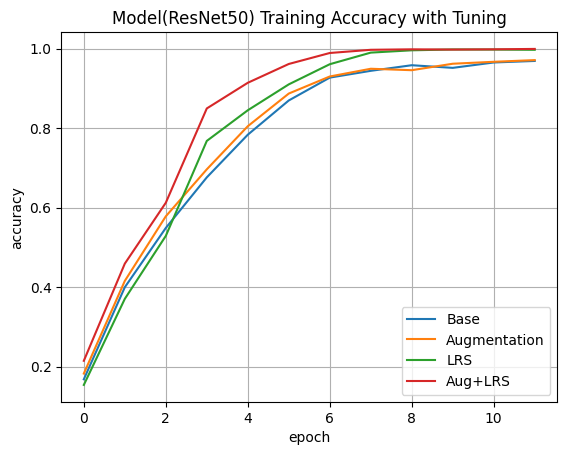

In [31]:
plt.plot(history['accuracy'])
plt.plot(history_aug.history['accuracy'])
plt.plot(history_lrs.history['accuracy'])
plt.plot(history_aug_lrs.history['accuracy'])
plt.title('Model(ResNet50) Training Accuracy with Tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Base', 'Augmentation','LRS', 'Aug+LRS'], loc='lower right')
plt.grid(True)
plt.show()